In [3]:
# @title 1. System Setup & Global Configuration
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import time
import csv
import glob
import shutil
import random
from datetime import datetime, timedelta

# Machine Learning Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

# Mount Google Drive
from google.colab import drive, userdata
drive.mount('/content/drive')

# --- GLOBAL CONFIGURATION ---
FOLDER_NAME = "Air_Quality_AI"
BASE_PATH = f"/content/drive/MyDrive/{FOLDER_NAME}"
RAW_FILE = f"{BASE_PATH}/london_bloomsbury_raw.csv"
CLEAN_FILE = f"{BASE_PATH}/london_bloomsbury_clean.csv"

# Ensure main directory exists
os.makedirs(BASE_PATH, exist_ok=True)

print(f"✅ Setup Complete. Working directory: {BASE_PATH}")
print(f"✅ TensorFlow Version: {tf.__version__}")
if tf.config.list_physical_devices('GPU'):
    print("🚀 GPU Detected.")
else:
    print("⚠️ No GPU detected. Go to Runtime > Change runtime type > T4 GPU.")

Mounted at /content/drive
✅ Setup Complete. Working directory: /content/drive/MyDrive/Air_Quality_AI
✅ TensorFlow Version: 2.19.0
🚀 GPU Detected.


In [ ]:
# @title 2. Data Acquisition
# SENSORS: London Bloomsbury (Station ID 148)
SENSORS_TO_DOWNLOAD = [
    {"id": 238, "name": "no2"},
    {"id": 229, "name": "o3"},
    {"id": 244, "name": "pm10"},
    {"id": 232, "name": "pm25"},
    {"id": 4933, "name": "so2"}
]

# TIME RANGE: 2016 to 2025
YEARS_TO_FETCH = range(2016, 2026)

try:
    API_KEY = userdata.get('OPENAQ_API_KEY')
except:
    API_KEY = None
    print("⚠️ WARNING: 'OPENAQ_API_KEY' not found in Secrets. Limits may apply.")

def download_data():
    headers = {"X-API-Key": API_KEY} if API_KEY else {}

    # Initialize File with Header
    with open(RAW_FILE, "w", encoding="utf-8", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["datetime", "station_id", "pollutant", "value", "unit"])

    total_records = 0
    print(f"--- 🚀 STARTING DOWNLOAD (Target: {RAW_FILE}) ---")

    for sensor in SENSORS_TO_DOWNLOAD:
        print(f"\n📡 Sensor: {sensor['name'].upper()} (ID: {sensor['id']})")

        for year in YEARS_TO_FETCH:
            print(f"   📅 Fetching {year}...", end='\r')
            params = {
                "limit": 1000,
                "page": 1,
                "datetime_from": f"{year}-01-01T00:00:00Z",
                "datetime_to": f"{year}-12-31T23:59:59Z"
            }
            url = f"https://api.openaq.org/v3/sensors/{sensor['id']}/measurements"

            while True:
                try:
                    r = requests.get(url, params=params, headers=headers, timeout=10)
                    if r.status_code == 200:
                        data = r.json().get('results', [])
                        if not data: break # End of year

                        # Write batch
                        with open(RAW_FILE, "a", encoding="utf-8", newline="") as f:
                            writer = csv.writer(f)
                            for entry in data:
                                writer.writerow([
                                    entry['period']['datetimeTo']['utc'],
                                    148,
                                    sensor['name'],
                                    entry['value'],
                                    entry['parameter']['units']
                                ])

                        total_records += len(data)
                        params["page"] += 1
                        time.sleep(0.1) # Be nice to API
                    elif r.status_code == 429:
                        time.sleep(5) # Rate limit
                    else:
                        break # Other error
                except Exception:
                    time.sleep(1) # Network blip

    print(f"\n✅ Download Complete. Total Records: {total_records}")

# Run the function
download_data()

--- 🚀 STARTING DOWNLOAD (Target: /content/drive/MyDrive/Air_Quality_AI/london_bloomsbury_raw.csv) ---

📡 Sensor: NO2 (ID: 238)

📡 Sensor: O3 (ID: 229)

📡 Sensor: PM10 (ID: 244)

📡 Sensor: PM25 (ID: 232)

📡 Sensor: SO2 (ID: 4933)

✅ Download Complete. Total Records: 334656


In [4]:
# @title 3. Data Cleaning (Pivot & Resample)
print(f"🧹 Processing file: {RAW_FILE}")
df_raw = pd.read_csv(RAW_FILE)
df_raw['datetime'] = pd.to_datetime(df_raw['datetime'])

# 1. Pivot: Turn pollutants into columns
df_wide = df_raw.pivot_table(index='datetime', columns='pollutant', values='value', aggfunc='mean')

# 2. Resample: Force strict hourly intervals
df_clean = df_wide.resample('1H').mean()

# 3. Interpolate: Fill gaps up to 24 hours
df_clean = df_clean.interpolate(method='time', limit=24)

# 4. Drop Drop remaining NaNs (large gaps)
df_final = df_clean.dropna()

# Save
df_final.to_csv(CLEAN_FILE)
print(f"✅ Clean Data Saved: {CLEAN_FILE}")
print(f"   Shape: {df_final.shape}")
print(f"   Features: {df_final.columns.tolist()}")
df_final.head()

🧹 Processing file: /content/drive/MyDrive/Air_Quality_AI/london_bloomsbury_raw.csv


/tmp/ipython-input-3996954728.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_clean = df_wide.resample('1H').mean()


✅ Clean Data Saved: /content/drive/MyDrive/Air_Quality_AI/london_bloomsbury_clean.csv
   Shape: (72935, 5)
   Features: ['no2', 'o3', 'pm10', 'pm25', 'so2']


pollutant,no2,o3,pm10,pm25,so2
datetime,,,,,
2016-02-27 21:00:00+00:00,46.00,35.00,33.00,25.00,13.00
2016-02-27 22:00:00+00:00,46.00,35.00,33.00,24.00,13.00
2016-02-27 23:00:00+00:00,49.00,35.00,32.00,24.00,13.00
2016-02-28 00:00:00+00:00,55.00,34.00,31.00,23.00,13.00
2016-02-28 01:00:00+00:00,54.64,34.04,30.28,22.32,12.88


In [6]:
# @title 4. Preprocessing Utilities
# Load the Clean Data
df = pd.read_csv(CLEAN_FILE, index_col='datetime', parse_dates=True)

# 1. Train/Test Split (80% Train, 20% Test)
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

print(f"Training Samples: {len(df_train)}")
print(f"Testing Samples:  {len(df_test)}")

# 2. Scaling (Fit ONLY on Training data to prevent leakage)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(df_train)
test_scaled = scaler.transform(df_test)

# 3. Sequence Generator Function
def split_sequences(sequences, n_steps_in, n_steps_out):
    """
    Converts a flat timeline into X (Input Window) and y (Target Window)
    """
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequences):
            break
        X.append(sequences[i:end_ix, :])
        y.append(sequences[end_ix:out_end_ix, :])
    return np.array(X), np.array(y)

print("✅ Scaler fitted and helper function defined.")

Training Samples: 58348
Testing Samples:  14587
✅ Scaler fitted and helper function defined.


In [ ]:
# @title 4. Train Model A (6h -> 3h)
# Config
N_IN = 6
N_OUT = 3
MODEL_NAME = "Model_A_6h"
CHECKPOINT_DIR = f"{BASE_PATH}/checkpoints_{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Data Reshaping
X_train, y_train = split_sequences(train_scaled, N_IN, N_OUT)
X_test, y_test = split_sequences(test_scaled, N_IN, N_OUT)

# Model Definition
model_a = Sequential([
    LSTM(200, activation='relu', input_shape=(N_IN, 5)),
    RepeatVector(N_OUT),
    LSTM(200, activation='relu', return_sequences=True),
    TimeDistributed(Dense(5))
])
model_a.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
print(f"🚀 Training {MODEL_NAME}...")
checkpoint = ModelCheckpoint(f"{CHECKPOINT_DIR}/epoch_{{epoch:02d}}.keras", verbose=1)
logger = CSVLogger(f"{BASE_PATH}/{MODEL_NAME}_log.csv")

history = model_a.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, logger],
    verbose=1
)
model_a.save(f"{BASE_PATH}/{MODEL_NAME}_final.keras")
print("✅ Training Complete.")

🚀 Training Model_A_6h...
Epoch 1/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0021 - mae: 0.0244
Epoch 1: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_A_6h/epoch_01.keras
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 0.0021 - mae: 0.0244 - val_loss: 4.5225e-04 - val_mae: 0.0125
Epoch 2/50
1814/1824 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4547e-04 - mae: 0.0118
Epoch 2: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_A_6h/epoch_02.keras
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 4.4537e-04 - mae: 0.0118 - val_loss: 3.9954e-04 - val_mae: 0.0102
Epoch 3/50
1823/1824 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0275e-04 - mae: 0.0109
Epoch 3: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_A_6h/epoch_03.keras
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 4.0275e-04 - mae: 0.0109 - val_loss: 3.9036e-04 - val_mae: 0.0104
Epoch 4/50
1824/1824 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.92

🔄 Loading Best Model_A_6h...
🏆 Loaded Epoch: 27
🔎 Analyzing Sample #2395...

📝 ACCURACY REPORT (Sample #2395)
POLLUTANT  | REAL (Avg)   | PREDICTED    | ERROR     
--------------------------------------------------
NO2        | 18.33        | 16.55        | 1.78      
O3         | 78.67        | 77.68        | 0.99      
PM10       | 9.67         | 9.79         | 0.12      
PM2.5      | 5.67         | 5.44         | 0.22      
SO2        | 5.00         | 4.39         | 0.61      


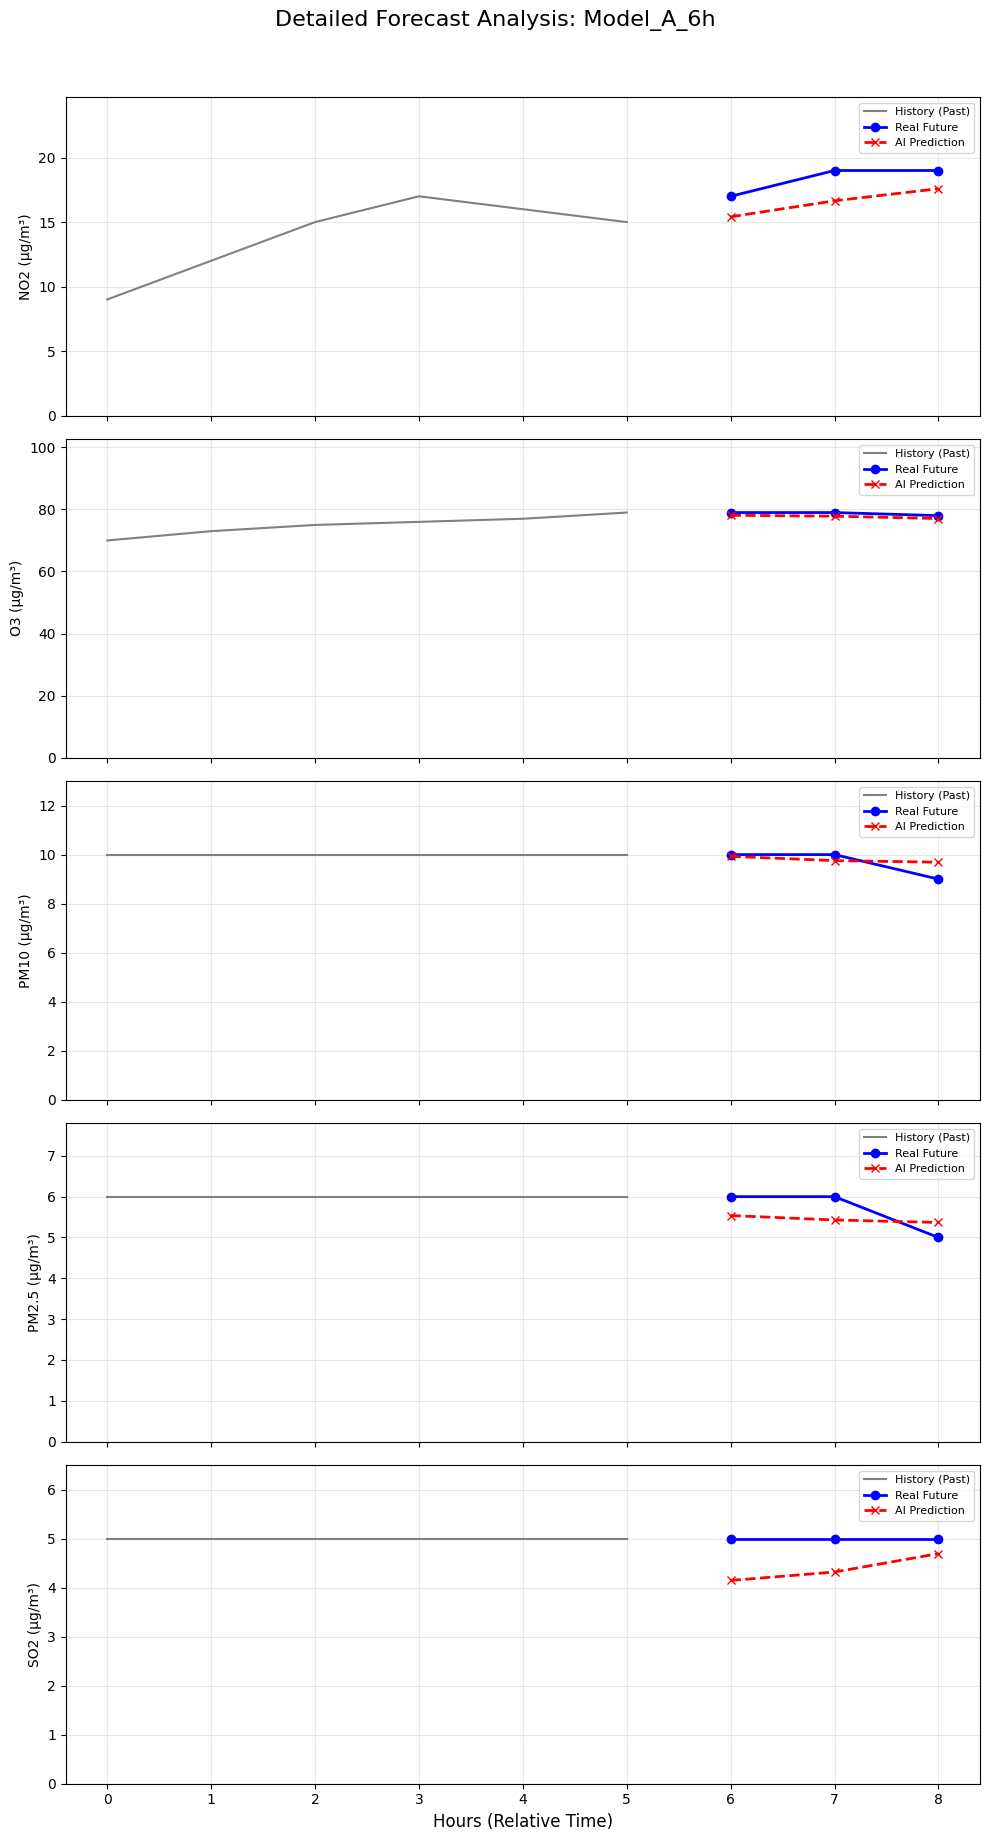

In [ ]:
# @title Test Model A (Detailed Visualization)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from tensorflow.keras.models import load_model

# ==========================================
# ⚙️ CONFIGURATION
# ==========================================
N_IN = 6       # Model A Input
N_OUT = 3      # Model A Output
MODEL_NAME = "Model_A_6h"
CHECKPOINT_DIR = f"{BASE_PATH}/checkpoints_{MODEL_NAME}"
POLLUTANTS = ["NO2", "O3", "PM10", "PM2.5", "SO2"]

# ==========================================
# 1. LOAD BEST MODEL
# ==========================================
print(f"🔄 Loading Best {MODEL_NAME}...")
try:
    log = pd.read_csv(f"{BASE_PATH}/{MODEL_NAME}_log.csv")
    best_epoch = log.loc[log['val_loss'].idxmin()]['epoch'] + 1
    model = load_model(f"{CHECKPOINT_DIR}/epoch_{int(best_epoch):02d}.keras")
    print(f"🏆 Loaded Epoch: {int(best_epoch)}")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    # Stop execution if model fails
    raise

# ==========================================
# 2. PREDICT RANDOM SAMPLE
# ==========================================
# Reshape Test Data
X_test, y_test = split_sequences(test_scaled, N_IN, N_OUT)

# Pick a random sample
idx = random.randint(0, len(X_test)-1)
print(f"🔎 Analyzing Sample #{idx}...")

# Predict
pred_scaled = model.predict(X_test[idx].reshape(1, N_IN, 5), verbose=0)

# Inverse Transform (Get Real Values)
real_hist = scaler.inverse_transform(X_test[idx])        # Past 6h
real_fut = scaler.inverse_transform(y_test[idx])         # Real Next 3h
pred_fut = scaler.inverse_transform(pred_scaled.reshape(N_OUT, 5)) # AI Next 3h

# ==========================================
# 3. GENERATE REPORT TABLE
# ==========================================
print(f"\n📝 ACCURACY REPORT (Sample #{idx})")
print(f"{'POLLUTANT':<10} | {'REAL (Avg)':<12} | {'PREDICTED':<12} | {'ERROR':<10}")
print("-" * 50)

for i, name in enumerate(POLLUTANTS):
    val_real = np.mean(real_fut[:, i])
    val_pred = np.mean(pred_fut[:, i])
    diff = abs(val_real - val_pred)
    print(f"{name:<10} | {val_real:<12.2f} | {val_pred:<12.2f} | {diff:<10.2f}")

# ==========================================
# 4. VISUALIZE (One Graph Per Indicator)
# ==========================================
fig, axes = plt.subplots(5, 1, figsize=(10, 18), sharex=True)
hours_hist = range(0, N_IN)
hours_fut = range(N_IN, N_IN + N_OUT)

for i, ax in enumerate(axes):
    name = POLLUTANTS[i]

    # 1. Plot History (Gray)
    ax.plot(hours_hist, real_hist[:, i], 'gray', label='History (Past)', linewidth=1.5)

    # 2. Plot Real Future (Blue)
    ax.plot(hours_fut, real_fut[:, i], 'b-o', label='Real Future', linewidth=2)

    # 3. Plot AI Prediction (Red)
    ax.plot(hours_fut, pred_fut[:, i], 'r--x', label='AI Prediction', linewidth=2)

    # Formatting
    max_val = max(real_hist[:, i].max(), real_fut[:, i].max())
    ax.set_ylim(0, max_val * 1.3) # Add headroom
    ax.set_ylabel(f"{name} (µg/m³)", fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='upper right', fontsize=8)

plt.xlabel("Hours (Relative Time)", fontsize=12)
plt.suptitle(f"Detailed Forecast Analysis: {MODEL_NAME}", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# @title 6. Train Model B (24h -> 12h)
# Config
N_IN = 24
N_OUT = 12
MODEL_NAME = "Model_B_24h"
CHECKPOINT_DIR = f"{BASE_PATH}/checkpoints_{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Data Reshaping
X_train, y_train = split_sequences(train_scaled, N_IN, N_OUT)
X_test, y_test = split_sequences(test_scaled, N_IN, N_OUT)

# Model Definition
model_b = Sequential([
    LSTM(200, activation='relu', input_shape=(N_IN, 5)),
    RepeatVector(N_OUT),
    LSTM(200, activation='relu', return_sequences=True),
    TimeDistributed(Dense(5))
])
model_b.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training
print(f"🚀 Training {MODEL_NAME}...")
checkpoint = ModelCheckpoint(f"{CHECKPOINT_DIR}/epoch_{{epoch:02d}}.keras", verbose=1)
logger = CSVLogger(f"{BASE_PATH}/{MODEL_NAME}_log.csv")

history = model_b.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, logger],
    verbose=1
)
model_b.save(f"{BASE_PATH}/{MODEL_NAME}_final.keras")
print("✅ Training Complete.")

🚀 Training Model_B_24h...
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1823/1823 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0316
Epoch 1: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_B_24h/epoch_01.keras
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 0.0029 - mae: 0.0316 - val_loss: 0.0013 - val_mae: 0.0200
Epoch 2/50
1819/1823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mae: 0.0220
Epoch 2: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_B_24h/epoch_02.keras
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0014 - mae: 0.0219 - val_loss: 0.0012 - val_mae: 0.0195
Epoch 3/50
1817/1823 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0013 - mae: 0.0213
Epoch 3: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_B_24h/epoch_03.keras
1823/1823 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.0013 - mae: 0.0213 - val_loss: 0.0013 - val_mae: 0.0198
Epoch 4/50
1822/1823 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - mae: 0.0210
Epoch 4: saving model to /content/drive/My

🏆 Loaded Model_B_24h (Epoch 11)


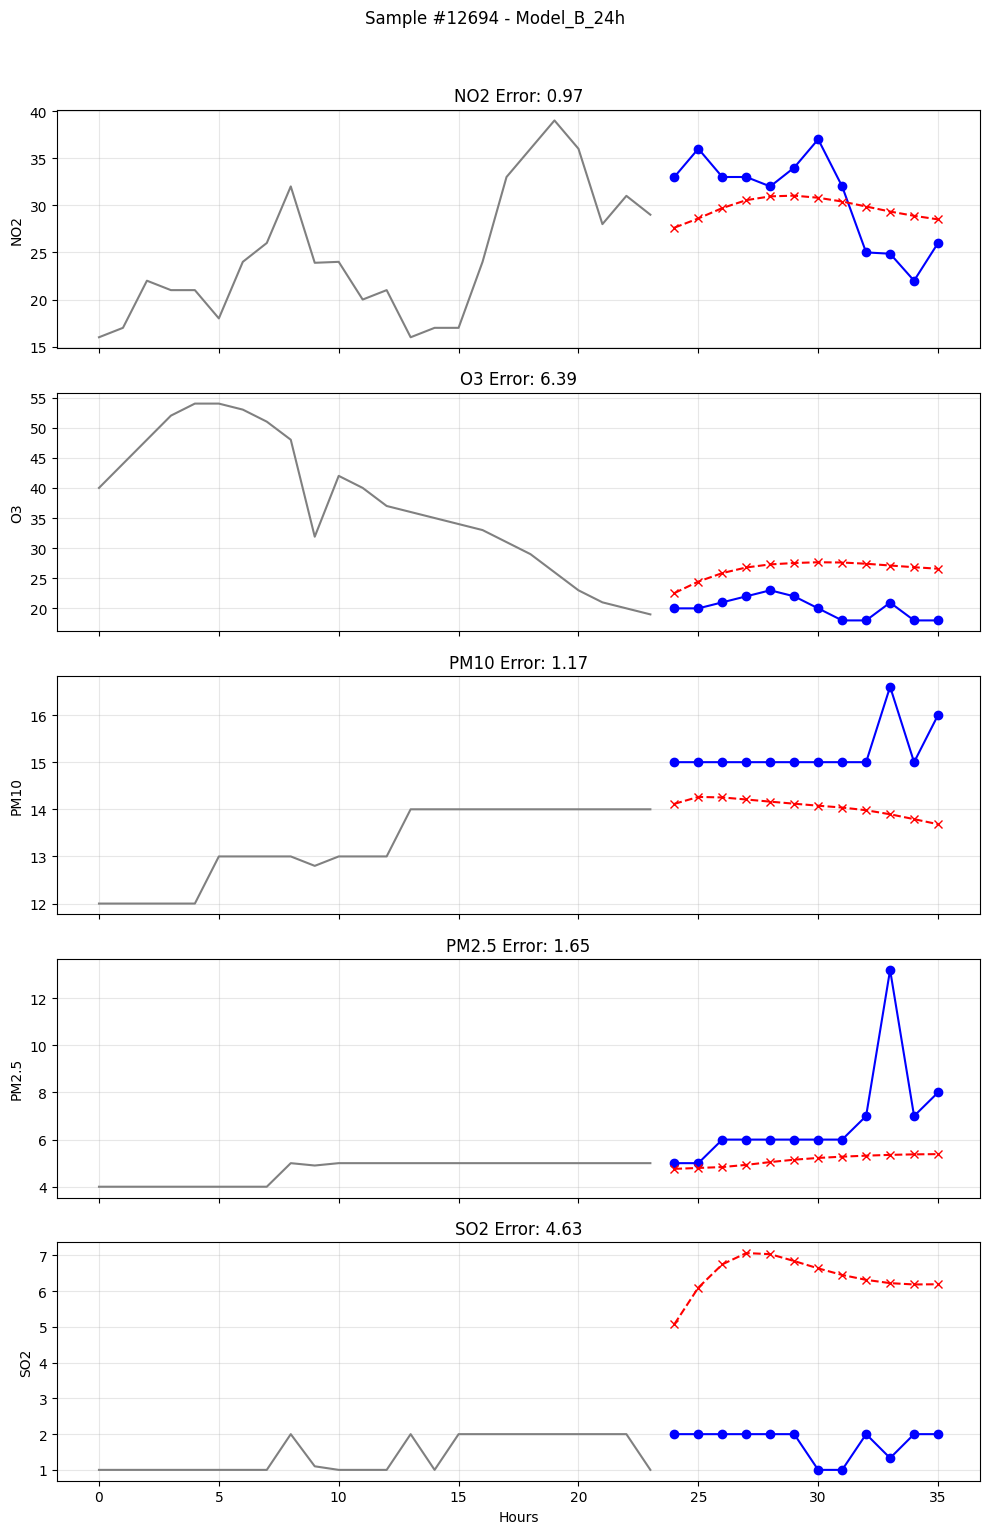

In [ ]:
# @title 7. Test Model B (Detailed Visualization)
MODEL_NAME = "Model_B_24h"
N_IN = 24
N_OUT = 12
POLLUTANTS = ["NO2", "O3", "PM10", "PM2.5", "SO2"]

# Load Best Epoch
log = pd.read_csv(f"{BASE_PATH}/{MODEL_NAME}_log.csv")
best_epoch = log.loc[log['val_loss'].idxmin()]['epoch'] + 1
model = load_model(f"{BASE_PATH}/checkpoints_{MODEL_NAME}/epoch_{int(best_epoch):02d}.keras")
print(f"🏆 Loaded {MODEL_NAME} (Epoch {int(best_epoch)})")

# Prepare Random Sample
X_test, y_test = split_sequences(test_scaled, N_IN, N_OUT)
idx = random.randint(0, len(X_test)-1)
pred_scaled = model.predict(X_test[idx].reshape(1, N_IN, 5), verbose=0)

# Inverse Transform
real_hist = scaler.inverse_transform(X_test[idx])
real_fut = scaler.inverse_transform(y_test[idx])
pred_fut = scaler.inverse_transform(pred_scaled.reshape(N_OUT, 5))

# Plot Panel
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
for i, ax in enumerate(axes):
    name = POLLUTANTS[i]
    ax.plot(range(0, N_IN), real_hist[:, i], 'gray', label='History')
    ax.plot(range(N_IN, N_IN+N_OUT), real_fut[:, i], 'b-o', label='Real')
    ax.plot(range(N_IN, N_IN+N_OUT), pred_fut[:, i], 'r--x', label='Predicted')
    ax.set_ylabel(name)
    ax.grid(True, alpha=0.3)

    err = abs(np.mean(real_fut[:, i]) - np.mean(pred_fut[:, i]))
    ax.set_title(f"{name} Error: {err:.2f}")

plt.xlabel("Hours")
plt.suptitle(f"Sample #{idx} - {MODEL_NAME}", y=1.02)
plt.tight_layout()
plt.show()

In [5]:
# @title 8. Train Model C (168h -> 12h)
# Config
N_IN = 168
N_OUT = 12
MODEL_NAME = "Model_C_168h"
CHECKPOINT_DIR = f"{BASE_PATH}/checkpoints_{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Data Reshaping
print("🔄 Reshaping for 7-Day Context...")
X_train, y_train = split_sequences(train_scaled, N_IN, N_OUT)
X_test, y_test = split_sequences(test_scaled, N_IN, N_OUT)

# Model Definition
model_c = Sequential([
    LSTM(100, activation='tanh', input_shape=(N_IN, 5)),
    RepeatVector(N_OUT),
    LSTM(100, activation='tanh', return_sequences=True),
    TimeDistributed(Dense(5))
])

# Gradient Clipping
opt = optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)
model_c.compile(optimizer=opt, loss='mse', metrics=['mae'])

# Training
print(f"🚀 Training {MODEL_NAME}...")
checkpoint = ModelCheckpoint(f"{CHECKPOINT_DIR}/epoch_{{epoch:02d}}.keras", verbose=1)
logger = CSVLogger(f"{BASE_PATH}/{MODEL_NAME}_log.csv")

history = model_c.fit(
    X_train, y_train, epochs=50, batch_size=32,
    validation_data=(X_test, y_test), callbacks=[checkpoint, logger], verbose=1
)
model_c.save(f"{BASE_PATH}/{MODEL_NAME}_final.keras")

🔄 Reshaping for 7-Day Context...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🚀 Training Model_C_168h...
Epoch 1/50
1815/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0052 - mae: 0.0433
Epoch 1: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_C_168h/epoch_01.keras
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - loss: 0.0051 - mae: 0.0433 - val_loss: 0.0020 - val_mae: 0.0261
Epoch 2/50
1816/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0020 - mae: 0.0270
Epoch 2: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_C_168h/epoch_02.keras
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 0.0020 - mae: 0.0270 - val_loss: 0.0014 - val_mae: 0.0216
Epoch 3/50
1817/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - mae: 0.0244
Epoch 3: saving model to /content/drive/MyDrive/Air_Quality_AI/checkpoints_Model_C_168h/epoch_03.keras
1818/1818 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - loss: 0.0016 - mae: 0.0244 - val_loss: 0.0014 - val_mae: 0.0212
Epoch 4/50
1814/1818 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - mae: 0.

🏆 Loaded Model_C_168h (Epoch 30)


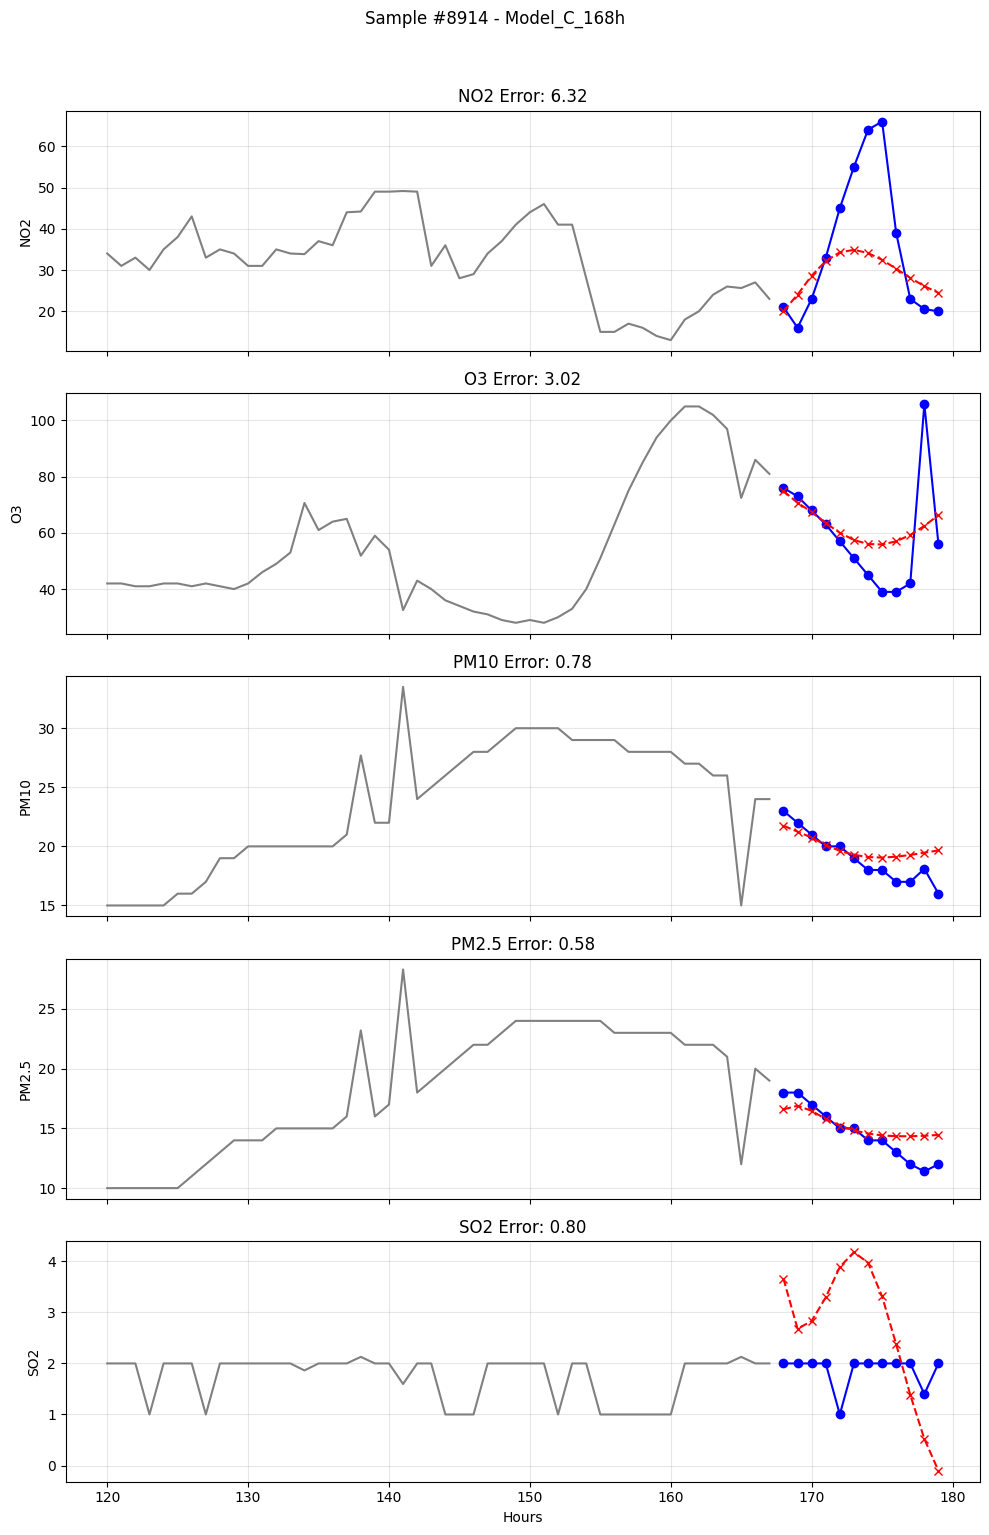

In [6]:
# @title 9. Test Model C (Detailed Visualization)
MODEL_NAME = "Model_C_168h"
N_IN = 168
N_OUT = 12
POLLUTANTS = ["NO2", "O3", "PM10", "PM2.5", "SO2"]

# Load Best Epoch
log = pd.read_csv(f"{BASE_PATH}/{MODEL_NAME}_log.csv")
best_epoch = log.loc[log['val_loss'].idxmin()]['epoch'] + 1
model = load_model(f"{BASE_PATH}/checkpoints_{MODEL_NAME}/epoch_{int(best_epoch):02d}.keras")
print(f"🏆 Loaded {MODEL_NAME} (Epoch {int(best_epoch)})")

# Prepare Random Sample
X_test, y_test = split_sequences(test_scaled, N_IN, N_OUT)
idx = random.randint(0, len(X_test)-1)
pred_scaled = model.predict(X_test[idx].reshape(1, N_IN, 5), verbose=0)

# Inverse Transform
real_hist = scaler.inverse_transform(X_test[idx])
real_fut = scaler.inverse_transform(y_test[idx])
pred_fut = scaler.inverse_transform(pred_scaled.reshape(N_OUT, 5))

# Plot Panel
fig, axes = plt.subplots(5, 1, figsize=(10, 15), sharex=True)
for i, ax in enumerate(axes):
    name = POLLUTANTS[i]
    # Zoom in on last 48h of history so graph is readable
    ax.plot(range(N_IN-48, N_IN), real_hist[-48:, i], 'gray', label='History (Zoomed)')
    ax.plot(range(N_IN, N_IN+N_OUT), real_fut[:, i], 'b-o', label='Real')
    ax.plot(range(N_IN, N_IN+N_OUT), pred_fut[:, i], 'r--x', label='Predicted')
    ax.set_ylabel(name)
    ax.grid(True, alpha=0.3)

    err = abs(np.mean(real_fut[:, i]) - np.mean(pred_fut[:, i]))
    ax.set_title(f"{name} Error: {err:.2f}")

plt.xlabel("Hours")
plt.suptitle(f"Sample #{idx} - {MODEL_NAME}", y=1.02)
plt.tight_layout()
plt.show()

In [7]:
# @title 10. Final Comparison (The Championship)
models_to_compare = [
    {"name": "Model A (6h->3h)", "in": 6, "out": 3, "path": "checkpoints_Model_A_6h", "log": "Model_A_6h_log.csv"},
    {"name": "Model B (24h->12h)", "in": 24, "out": 12, "path": "checkpoints_Model_B_24h", "log": "Model_B_24h_log.csv"},
    {"name": "Model C (168h->12h)", "in": 168, "out": 12, "path": "checkpoints_Model_C_168h", "log": "Model_C_168h_log.csv"}
]

print(f"{'MODEL':<20} | {'MAE (Error)':<12} | {'R² SCORE (Accuracy)':<20}")
print("-" * 60)

for m in models_to_compare:
    log_path = f"{BASE_PATH}/{m['log']}"
    if os.path.exists(log_path):
        # 1. Find Best Epoch
        log = pd.read_csv(log_path)
        best_epoch = log.loc[log['val_loss'].idxmin()]['epoch'] + 1

        # 2. Load Model
        model_path = f"{BASE_PATH}/{m['path']}/epoch_{int(best_epoch):02d}.keras"
        model = load_model(model_path)

        # 3. Prepare Test Data specific to this model
        X_test, y_test = split_sequences(test_scaled, m['in'], m['out'])

        # 4. MAE (Overall Error)
        _, mae = model.evaluate(X_test, y_test, verbose=0)

        # 5. R2 Score (Truth Test on 1000 samples)
        subset = 1000
        pred_scaled = model.predict(X_test[:subset], verbose=0)

        # Inverse Transform
        pred_real = scaler.inverse_transform(pred_scaled.reshape(-1, 5))
        y_real = scaler.inverse_transform(y_test[:subset].reshape(-1, 5))

        # Calculate R2 for PM2.5 (Index 3)
        r2 = r2_score(y_real[:, 3], pred_real[:, 3])

        print(f"{m['name']:<20} | {mae:<12.5f} | {r2:<20.4f}")
    else:
        print(f"{m['name']:<20} | NOT FOUND    | N/A")

MODEL                | MAE (Error)  | R² SCORE (Accuracy) 
------------------------------------------------------------
Model A (6h->3h)     | 0.00898      | 0.9310              
Model B (24h->12h)   | 0.01781      | 0.7471              
Model C (168h->12h)  | 0.01775      | 0.7826              


In [7]:
import joblib
# Assuming 'scaler' is your fitted MinMaxScaler
joblib.dump(scaler, f"{BASE_PATH}/scaler.pkl")
print(f"✅ Scaler saved to {BASE_PATH}/scaler.pkl")

✅ Scaler saved to /content/drive/MyDrive/Air_Quality_AI/scaler.pkl
